In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression, r_regression, mutual_info_regression
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures, SplineTransformer, KBinsDiscretizer, \
     StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, get_scorer_names, accuracy_score, f1_score, precision_score, \
     confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, KFold, train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
import warnings
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv('allTrain.tsv', sep='\t', low_memory=True)
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
df.type = pd.Categorical(df.type.astype('category'))
df.type = df.type.cat.codes

In [9]:
test_idx = [2, 4, 5, 13, 15, 19, 24, 30, 34, 36, 38, 40, 44, 46]
labels = df[['Rapamycin_response', 'Mitomycin_response', 'Fulvestrant_response', 'Gefitinib_response', 'Rapamycin-Gefitinib_response', 'Mitomycin-Fulvestrant_response']]

In [10]:
features = df.drop(columns=labels.columns.to_list()+constant_columns, axis=1)
label = labels.Rapamycin_response
X_train, X_test, y_train, y_test = features.drop(test_idx, axis=0).reset_index(drop=True), features.iloc[features.index[test_idx]], labels.drop(test_idx, axis=0).reset_index(drop=True), labels.iloc[labels.index[test_idx]]

In [11]:
mut_features = features.select_dtypes(include=['int'])
rna_features = features.select_dtypes(include=['float'])

In [117]:
{i:drug for i, drug in enumerate(['Rapamycin_response', 'Mitomycin_response', 'Fulvestrant_response', 'Gefitinib_response', 'Rapamycin-Gefitinib_response', 'Mitomycin-Fulvestrant_response'])}

{0: 'Rapamycin_response',
 1: 'Mitomycin_response',
 2: 'Fulvestrant_response',
 3: 'Gefitinib_response',
 4: 'Rapamycin-Gefitinib_response',
 5: 'Mitomycin-Fulvestrant_response'}

In [ ]:
import wandb



In [104]:
def calc_shap(pipe, label):
    pipe.fit(X_train, y_train[label])
    model = pipe.named_steps['model']
    feat_bool = pipe.named_steps['select_feats'].get_support()
    selected_feats = X_train.iloc[:,feat_bool]
    print(f"------{ pipe['model'].__class__.__name__ }-----")
    explainer = shap.KernelExplainer(model.predict, selected_feats)
    shap_values = explainer.shap_values(X_test.iloc[:,feat_bool])
    shap.summary_plot(shap_values, X_test.iloc[:,feat_bool])

def run_cv(pipe, label, splits=4):
    cv_ = StratifiedKFold(n_splits=splits, shuffle=True, random_state=2)
    scores = cross_validate(pipe, X_train, y_train[label], cv=cv_, scoring=['balanced_accuracy', 'f1_weighted'], n_jobs=-1)
    return {'accuracy': np.nanmean(scores['test_balanced_accuracy']),
            'accuracy_std': np.nanstd(scores['test_balanced_accuracy']),
            'f1': np.nanmean(scores['test_f1_weighted']),
            'f1_std': np.nanstd(scores['test_f1_weighted'])}

def run_test(pipe, imp_feats, label):
    pipe.fit(X_train[imp_feats], y_train[label])
    pred = pipe.predict(X_test[imp_feats])
    bas = balanced_accuracy_score(y_test[label], pred)
    f1 = f1_score(y_test[label], pred, average='weighted')
    cm = confusion_matrix(y_test[label], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative response', 'Positive response'])
    print(f"------{ pipe['model'].__class__.__name__ }-----")
    disp.plot(cmap='Blues', values_format='.4g')
    print(classification_report(y_test[label], pred))
    plt.show()

In [13]:
numeric_transformer = imbPipeline([
      # ('bin', KBinsDiscretizer(encode='ordinal', strategy='kmeans')),
      ('scale', StandardScaler()),
      # ('pca', PCA(0.9995)),
      # ('select_feats', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1'))),
      # ('poly_feats', PolynomialFeatures(degree=2, interaction_only=True))
])
categorical_transformer = Pipeline([
      ('encoder', OrdinalEncoder()),
])

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, rna_features.columns),
        # ('cat', categorical_transformer, ['type'])
    ],
    remainder='passthrough'
)

In [15]:
lr_params={
    'fit_intercept':True,
    'C':1.0,
    'solver':'lbfgs',
    'penalty': 'l2',
    'random_state':42,
}

In [22]:
all_cols = features.columns.tolist()
cat_cols = mut_features.columns.to_list()
cat_bool = []
for col in all_cols:
    if col in cat_cols:
        cat_bool.append(True)
    else:
        cat_bool.append(False)
cat_bool = np.array(cat_bool)

In [30]:
pipe = imbPipeline([
    ('select_feats', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1', random_state=2, max_iter=420))),
    ('sampler', SMOTENC(categorical_features=cat_bool, k_neighbors=7)),
    ('model', XGBClassifier())
])
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'select_feats', 'model', 'select_feats__estimator__C', 'select_feats__estimator__class_weight', 'select_feats__estimator__dual', 'select_feats__estimator__fit_intercept', 'select_feats__estimator__intercept_scaling', 'select_feats__estimator__l1_ratio', 'select_feats__estimator__max_iter', 'select_feats__estimator__multi_class', 'select_feats__estimator__n_jobs', 'select_feats__estimator__penalty', 'select_feats__estimator__random_state', 'select_feats__estimator__solver', 'select_feats__estimator__tol', 'select_feats__estimator__verbose', 'select_feats__estimator__warm_start', 'select_feats__estimator', 'select_feats__importance_getter', 'select_feats__max_features', 'select_feats__norm_order', 'select_feats__prefit', 'select_feats__threshold', 'model__objective', 'model__use_label_encoder', 'model__base_score', 'model__booster', 'model__callbacks', 'model__colsample_bylevel', 'model__colsample_bynode', 'model__colsample_bytree', 'model__early_

In [1]:
lr = LogisticRegression(**lr_params, class_weight='balanced', max_iter=1000)
svmr = SVC(kernel='rbf', class_weight='balanced', probability=True)
svmp = SVC(kernel='poly', degree=3, class_weight='balanced', probability=True)
svml = SVC(kernel='linear', class_weight='balanced', probability=True)
svms = SVC(kernel='sigmoid', class_weight='balanced', probability=True)
dtc = DecisionTreeClassifier(class_weight='balanced', random_state=420)
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# lgbm = lgb.LGBMClassifier(class_weight='balanced')

lgbm = LGBMClassifier(
    boosting_type='gbdt',           # Gradient Boosting Decision Tree
    objective='binary',             # Binary classification
    metric='binary_logloss',        # Logarithmic loss for binary classification
    class_weight='balanced',
    learning_rate=0.01,              # Step size shrinkage to prevent overfitting
    n_estimators=100,               # Number of boosting rounds (trees)
    max_depth=5,                   # Maximum depth of the tree (unlimited)
    num_leaves=4,                  # Maximum number of leaves in one tree
    subsample=1.0,                  # Subsample ratio of the training instances
    colsample_bytree=1.0,           # Subsample ratio of columns when constructing each tree
    reg_alpha=0.0,                  # L1 regularization term on weights
    reg_lambda=0.0,                 # L2 regularization term on weights
    min_child_samples=2,           # Minimum number of data needed in a child (leaf)
    random_state=42,                # Seed for reproducibility
    n_jobs=-1                       # Use all available CPU cores
)
xgb = XGBClassifier()
vcs = VotingClassifier(estimators=[('svcp', svmp), ('lgbm', lgbm), ('svcl', svml), ('rf', rf), ('xgb', xgb), ('dtc', dtc)], voting='hard', weights=[2, 2, 2.5, 2, 1, 1])
vch = VotingClassifier(estimators=[('svcr', svmr), ('lgbm', lgbm), ('svcp', svmp), ('svcl', svml), ('rf', rf), ('xgb', xgb), ('dtc', dtc)], voting='soft')
sc = StackingClassifier(estimators=[('vch', vch), ('xgb', xgb), ('lgbm', lgbm), ('rf', rf), ('vcs', vcs)], stack_method='predict', final_estimator=dtc)
scp = StackingClassifier(estimators=[('vch', vch), ('xgb', xgb), ('lgbm', lgbm), ('rf', rf), ('svcs', svms),('svcr', svmr), ('svcp', svmp), ('svcl', svml), ('lr', lr)], stack_method='predict_proba', final_estimator=dtc)
scd = StackingClassifier(estimators=[('svcr', svmr), ('svcp', svmp), ('svcl', svml), ('lr', lr)], stack_method='decision_function', final_estimator=dtc)
scd2 = StackingClassifier(estimators=[('svcr', svmr), ('svcp', svmp), ('svcl', svml), ('lr', lr)], stack_method='decision_function', final_estimator=svml)

models = [lr, dtc, svmr, svmp, svml, svms, rf, lgbm, xgb, vcs, vch, sc, scp, scd, scd2]
models_fs = [LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', random_state=2, max_iter=420), rf, lgbm, dtc]

NameError: name 'LogisticRegression' is not defined

In [68]:
i=0
feat_sel_name = [f'{fsm.__class__.__name__}-{i}']
feat_sel_name

['DecisionTreeClassifier-0']

In [95]:
cv_results = pd.DataFrame()
row_res = {'feat_sel_name': 'LogisticRegression-0',
             'model_name': 'LogisticRegression-0',
             'accuracy': 0.6583333333333333,
             'accuracy_std': 0.10655593210453687,
             'f1': 0.6498931623931625,
             'f1_std': 0.6498931623931625}
cv_results.append(row_res, ignore_index=True)

,feat_sel_name,model_name,accuracy,accuracy_std,f1,f1_std
0,LogisticRegression-0,LogisticRegression-0,0.658333,0.106556,0.649893,0.649893


In [114]:
cv_results2 = pd.DataFrame()
row_res = {}
for i, fsm in enumerate(models_fs):
    print(f"----------------------{fsm.__class__.__name__}--------------------")
    for j, model in enumerate(models):
        print(f"----------------------{model.__class__.__name__}--------------------")
        row_res['feat_sel_name'] = f'{fsm.__class__.__name__}-{i}'
        row_res['model_name'] = f'{model.__class__.__name__}-{j}'
        pipe = imbPipeline([
            ('sampler', SVMSMOTE(random_state=42, m_neighbors=5)),
            ('select_feats', SelectFromModel(fsm)),
            # ('poly_feats', PolynomialFeatures(degree=2, interaction_only=True)),
            ('model', model)
        ])
        res = run_cv(pipe, 'Rapamycin_response', splits=4)
        row_res.update(res)
        cv_results2 = cv_results2.append(row_res, ignore_index=True)
        # print(row_res)
        row_res = {}

----------------------LogisticRegression--------------------
----------------------LogisticRegression--------------------
----------------------DecisionTreeClassifier--------------------
----------------------SVC--------------------
----------------------SVC--------------------
----------------------SVC--------------------
----------------------SVC--------------------
----------------------RandomForestClassifier--------------------
----------------------LGBMClassifier--------------------
----------------------XGBClassifier--------------------
----------------------VotingClassifier--------------------
----------------------VotingClassifier--------------------
----------------------StackingClassifier--------------------
----------------------StackingClassifier--------------------
----------------------StackingClassifier--------------------
----------------------RandomForestClassifier--------------------
----------------------LogisticRegression--------------------
----------------------De

In [118]:
cv_results2.sort_values(['accuracy', 'accuracy_std'], ascending=False)

,feat_sel_name,model_name,accuracy,accuracy_std,f1,f1_std
6,LogisticRegression-0,RandomForestClassifier-6,0.731250,0.115075,0.719734,0.113324
41,LGBMClassifier-2,StackingClassifier-13,0.727083,0.061343,0.717298,0.089438
32,LGBMClassifier-2,SVC-4,0.677083,0.132730,0.659758,0.135488
17,RandomForestClassifier-1,SVC-3,0.675000,0.164886,0.661131,0.165910
3,LogisticRegression-0,SVC-3,0.668750,0.174441,0.629563,0.202415
18,RandomForestClassifier-1,SVC-4,0.668750,0.145102,0.661679,0.146785
27,RandomForestClassifier-1,StackingClassifier-13,0.660417,0.071535,0.665972,0.068052
0,LogisticRegression-0,LogisticRegression-0,0.658333,0.106556,0.649893,0.124450
10,LogisticRegression-0,VotingClassifier-10,0.658333,0.106556,0.649893,0.124450
34,LGBMClassifier-2,RandomForestClassifier-6,0.645833,0.087500,0.604167,0.160024


In [113]:
cv_results.sort_values(['accuracy', 'accuracy_std'], ascending=False)

,feat_sel_name,model_name,accuracy,accuracy_std,f1,f1_std
6,LogisticRegression-0,RandomForestClassifier-6,0.695833,0.099739,0.699074,0.104859
0,LogisticRegression-0,LogisticRegression-0,0.689583,0.066242,0.687988,0.076691
18,RandomForestClassifier-1,SVC-4,0.675000,0.114564,0.665250,0.114795
11,LogisticRegression-0,StackingClassifier-11,0.670833,0.088682,0.671296,0.094540
27,RandomForestClassifier-1,StackingClassifier-13,0.666667,0.136550,0.659193,0.131185
26,RandomForestClassifier-1,StackingClassifier-12,0.654167,0.130504,0.659561,0.124870
3,LogisticRegression-0,SVC-3,0.643750,0.144021,0.597817,0.168184
34,LGBMClassifier-2,RandomForestClassifier-6,0.641667,0.094097,0.621212,0.089847
14,RandomForestClassifier-1,LogisticRegression-0,0.637500,0.198037,0.613095,0.212227
32,LGBMClassifier-2,SVC-4,0.629167,0.172452,0.621771,0.167182


----------------------LGBMClassifier--------------------
------LogisticRegression-----
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.50      0.67      0.57         6

    accuracy                           0.57        14
   macro avg       0.58      0.58      0.57        14
weighted avg       0.60      0.57      0.57        14



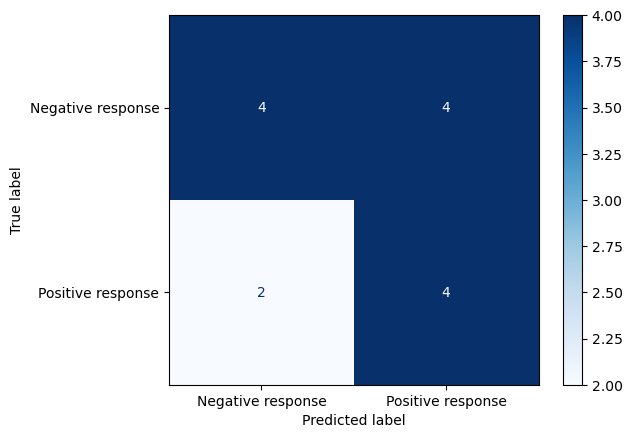

------DecisionTreeClassifier-----
              precision    recall  f1-score   support

           0       0.50      0.62      0.56         8
           1       0.25      0.17      0.20         6

    accuracy                           0.43        14
   macro avg       0.38      0.40      0.38        14
weighted avg       0.39      0.43      0.40        14



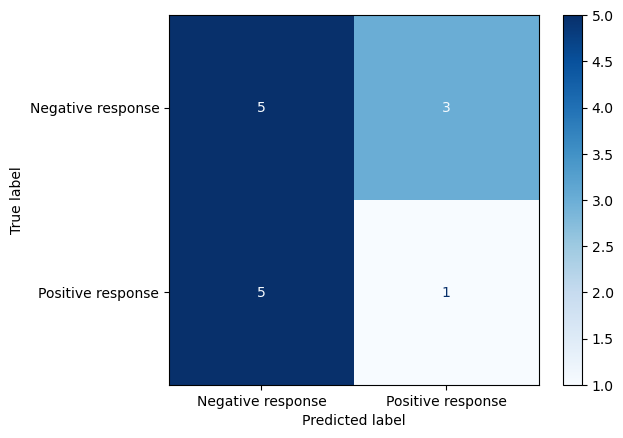

------SVC-----
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.50      0.67      0.57         6

    accuracy                           0.57        14
   macro avg       0.58      0.58      0.57        14
weighted avg       0.60      0.57      0.57        14



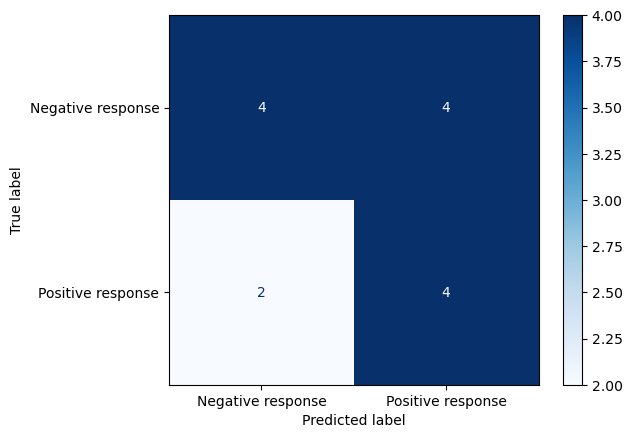

------SVC-----
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.50      0.67      0.57         6

    accuracy                           0.57        14
   macro avg       0.58      0.58      0.57        14
weighted avg       0.60      0.57      0.57        14



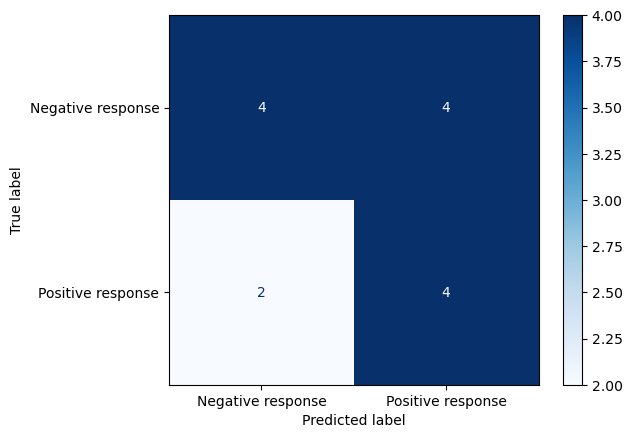

------SVC-----
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.50      0.67      0.57         6

    accuracy                           0.57        14
   macro avg       0.58      0.58      0.57        14
weighted avg       0.60      0.57      0.57        14



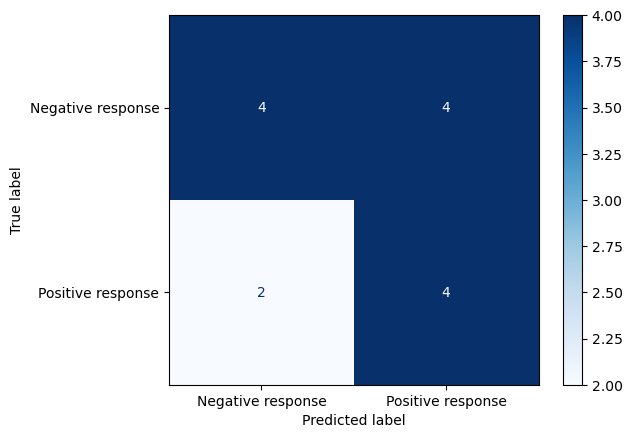

------SVC-----
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.80      0.67      0.73         6

    accuracy                           0.79        14
   macro avg       0.79      0.77      0.78        14
weighted avg       0.79      0.79      0.78        14



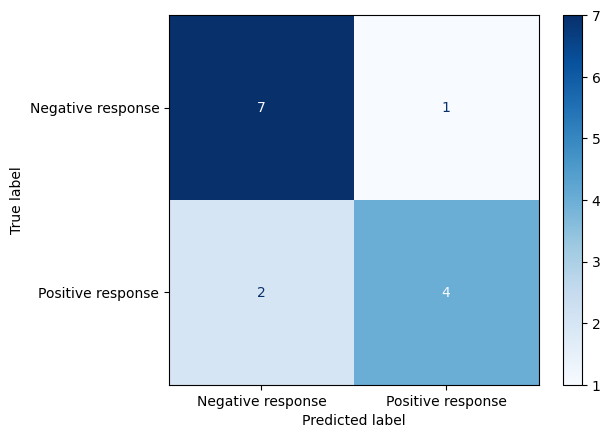

------RandomForestClassifier-----
              precision    recall  f1-score   support

           0       0.50      0.62      0.56         8
           1       0.25      0.17      0.20         6

    accuracy                           0.43        14
   macro avg       0.38      0.40      0.38        14
weighted avg       0.39      0.43      0.40        14



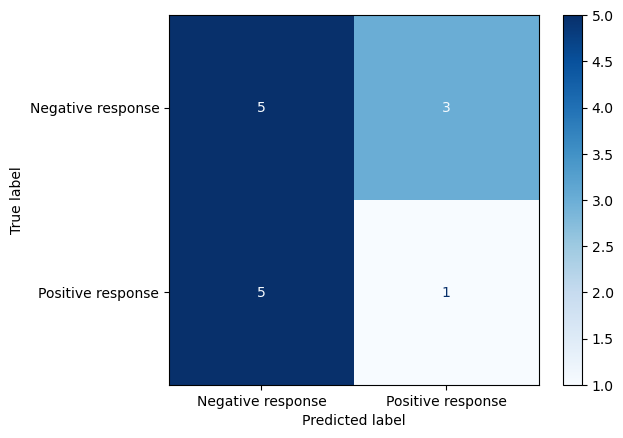

------LGBMClassifier-----
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.40      0.33      0.36         6

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14



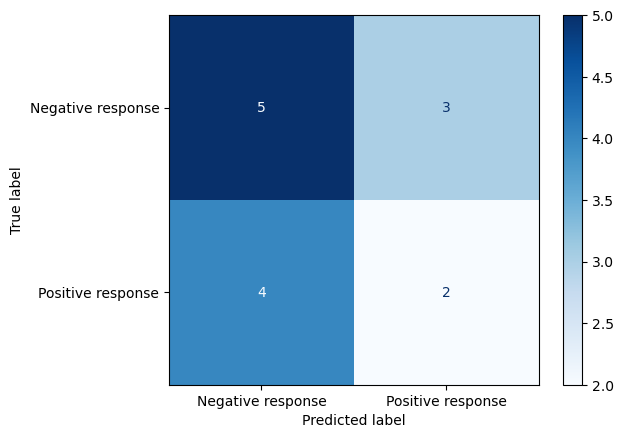

------XGBClassifier-----
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.50      0.50      0.50         6

    accuracy                           0.57        14
   macro avg       0.56      0.56      0.56        14
weighted avg       0.57      0.57      0.57        14



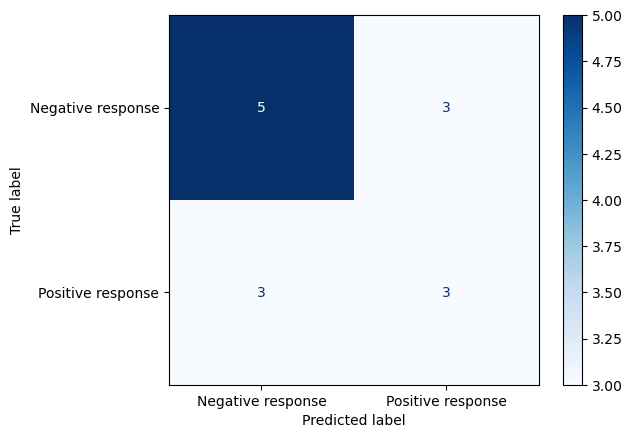

------VotingClassifier-----
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.40      0.33      0.36         6

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14



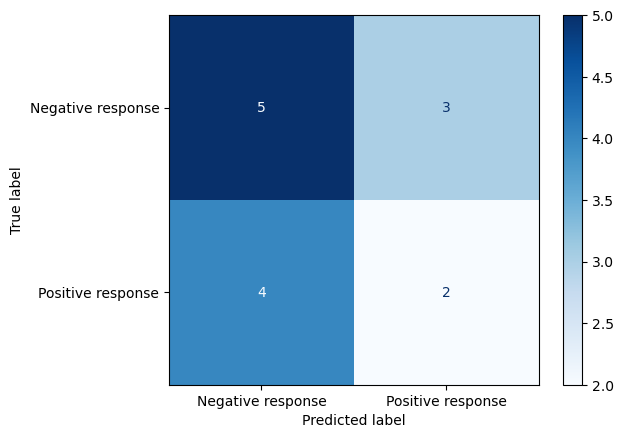

------VotingClassifier-----
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.40      0.33      0.36         6

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14



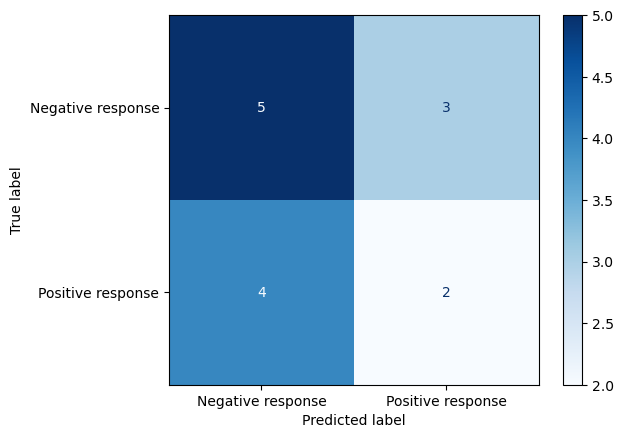

------StackingClassifier-----
              precision    recall  f1-score   support

           0       0.50      0.62      0.56         8
           1       0.25      0.17      0.20         6

    accuracy                           0.43        14
   macro avg       0.38      0.40      0.38        14
weighted avg       0.39      0.43      0.40        14



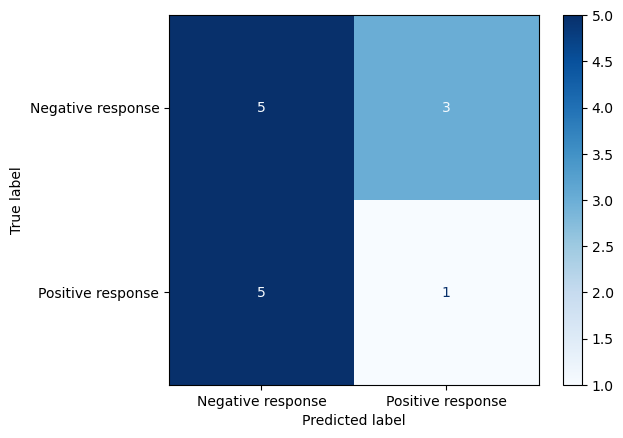

------StackingClassifier-----
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.50      0.50      0.50         6

    accuracy                           0.57        14
   macro avg       0.56      0.56      0.56        14
weighted avg       0.57      0.57      0.57        14



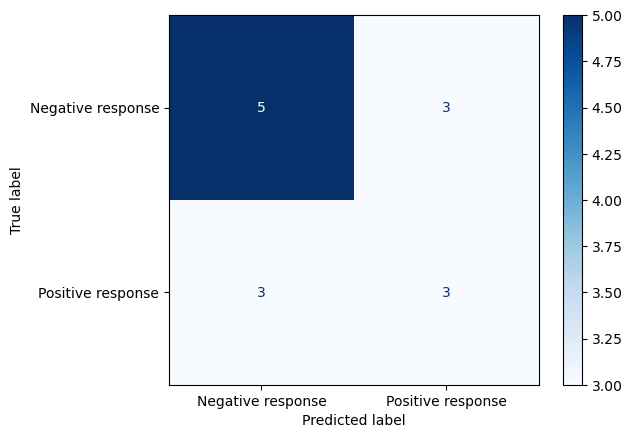

------StackingClassifier-----
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.43      0.50      0.46         6

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.51      0.50      0.50        14



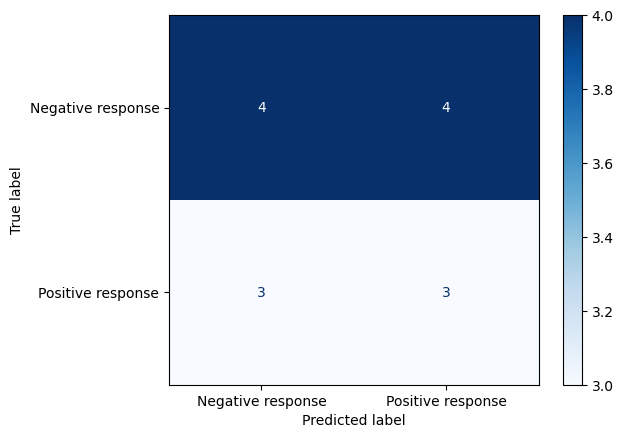

In [120]:
fsm = lgbm

print(f"----------------------{fsm.__class__.__name__}--------------------")
for model in models:
    pipe = imbPipeline([
        ('sampler', SVMSMOTE(random_state=42, m_neighbors=5)),
        ('select_feats', SelectFromModel(fsm)),
        ('model', model)
    ])
    run_test(pipe, X_train.columns.to_list(), 'Rapamycin_response')

----------------------LGBMClassifier--------------------
------LogisticRegression-----


  0%|          | 0/14 [00:00<?, ?it/s]

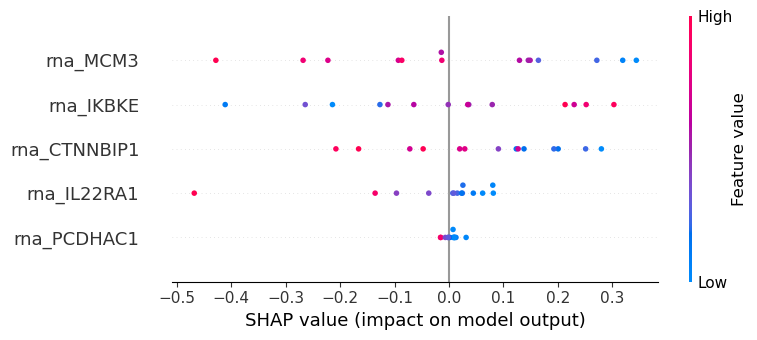

------DecisionTreeClassifier-----


  0%|          | 0/14 [00:00<?, ?it/s]

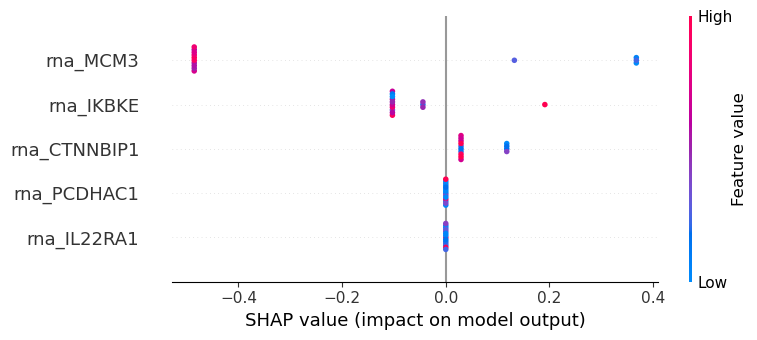

------SVC-----


  0%|          | 0/14 [00:00<?, ?it/s]

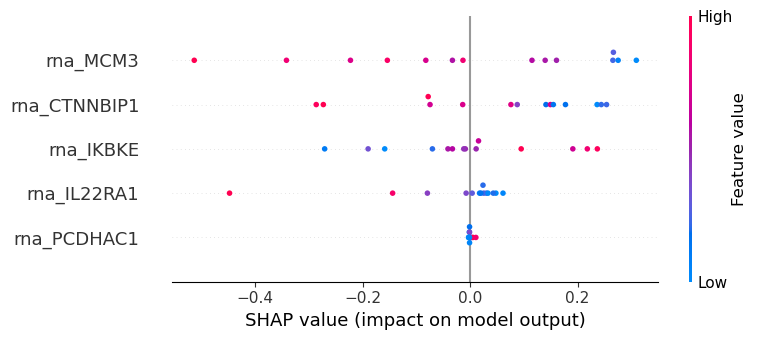

------SVC-----


  0%|          | 0/14 [00:00<?, ?it/s]

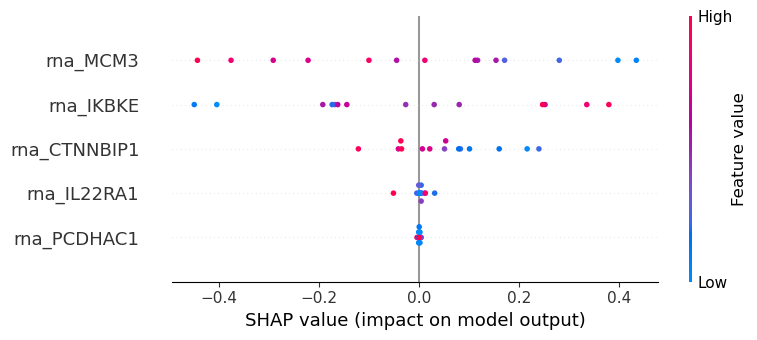

------SVC-----


  0%|          | 0/14 [00:00<?, ?it/s]

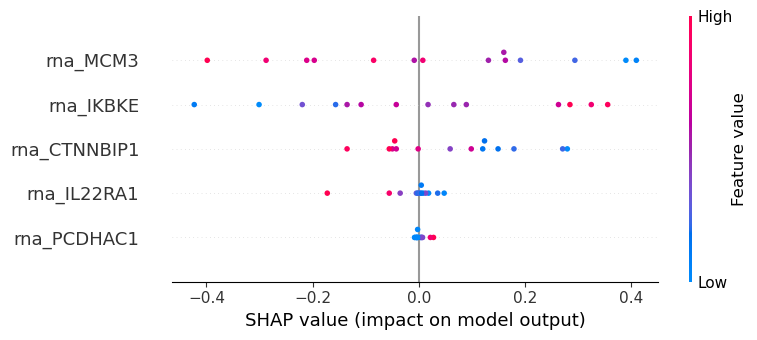

------SVC-----


  0%|          | 0/14 [00:00<?, ?it/s]

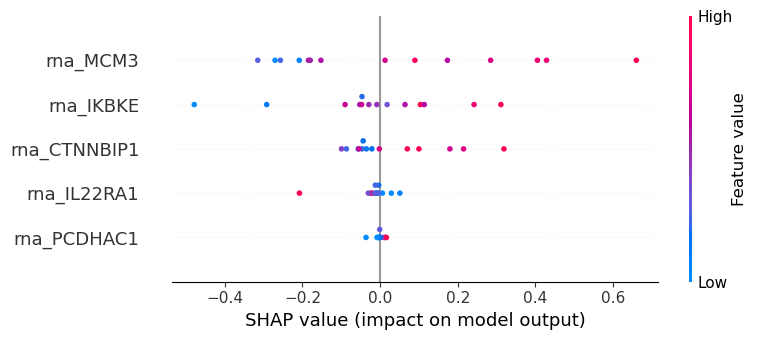

------RandomForestClassifier-----


  0%|          | 0/14 [00:00<?, ?it/s]

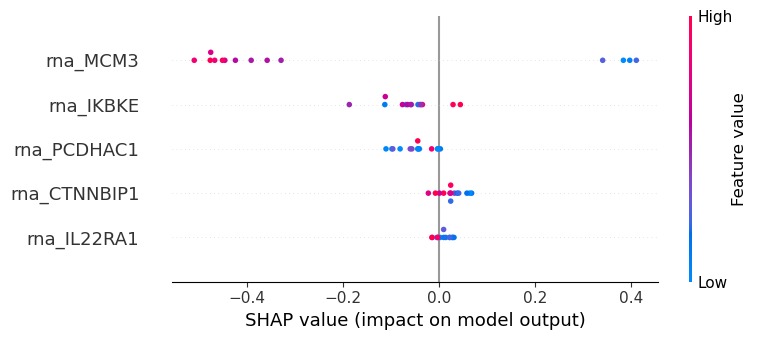

------LGBMClassifier-----


  0%|          | 0/14 [00:00<?, ?it/s]

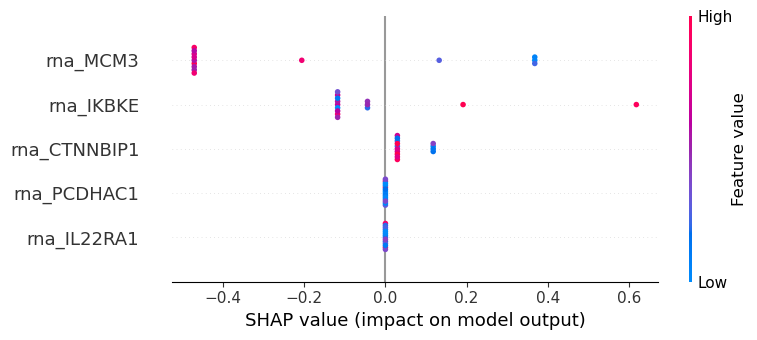

------XGBClassifier-----


  0%|          | 0/14 [00:00<?, ?it/s]

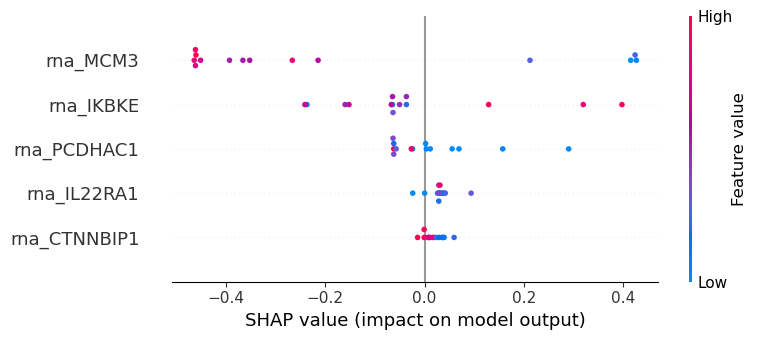

------VotingClassifier-----


  0%|          | 0/14 [00:00<?, ?it/s]

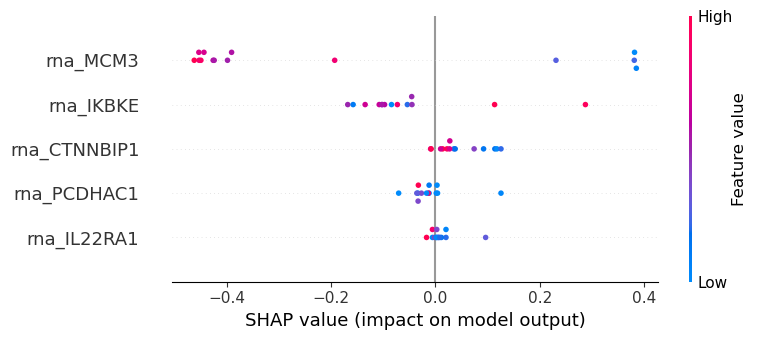

------VotingClassifier-----


  0%|          | 0/14 [00:00<?, ?it/s]

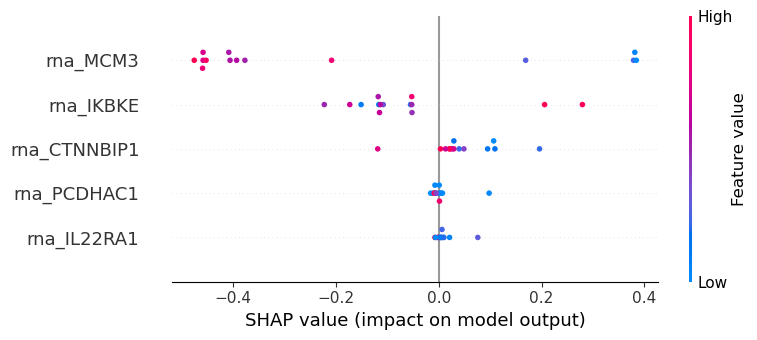

------StackingClassifier-----


  0%|          | 0/14 [00:00<?, ?it/s]

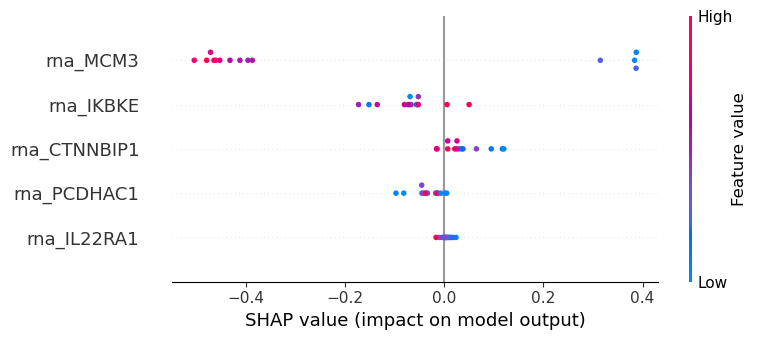

------StackingClassifier-----


  0%|          | 0/14 [00:00<?, ?it/s]

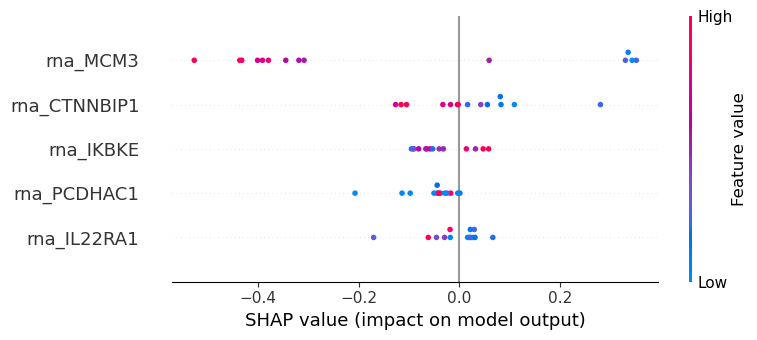

------StackingClassifier-----


  0%|          | 0/14 [00:00<?, ?it/s]

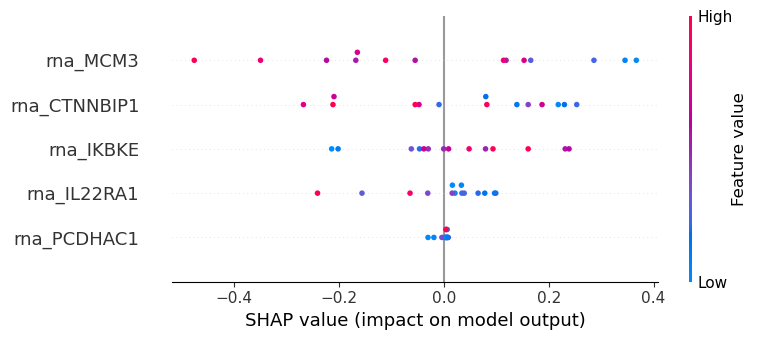

In [121]:
fsm = lgbm
print(f"----------------------{fsm.__class__.__name__}--------------------")
for model in models:
    pipe = imbPipeline([
        ('sampler', SVMSMOTE(random_state=42, m_neighbors=5)),
        ('select_feats', SelectFromModel(fsm, max_features=100)),
        ('model', model)
    ])
    calc_shap(pipe, 'Rapamycin_response')